# LSGANs - Least Squares Generative Adversarial Networks

Brief introduction to Least Squares Generative Adversarial Networks or LSGANs. This notebook is organized as follows:

1. **Research Paper**
2. **Background**
3. **Definition**
4. **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Least Squares Generative Adversarial Networks](https://arxiv.org/pdf/1611.04076.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Least Squares Generative Adversarial Networks (LSGANs) adopt the **least squares loss function** for the discriminator. 

The least squares loss function is able to move the fake samples toward the decision boundary, because the least squares loss function penalizes samples that lie in a long way on the correct side of the decision boundary. 

Another benefit of LSGANs is the improved stability of learning process.

### Network Design

<img src="../../img/network_design_gan.png" width="600"> 


### Cost Funcion

$$ 
\begin{aligned}
    \underset{D}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{x\sim p_{data}(x)}[(D(x)-b)^2] + \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-a)^2] \\
    \underset{G}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-c)^2]
\end{aligned}
$$

where $a$ and $b$ are the labels for fake data and real data, respectively, and $c$ denotes the value that G wants D to believe for fake data.

## 4. Training LSGANs with MNIST dataset, Keras and TensorFlow

* Data
    * Rescale the MNIST images to be between -1 and 1.

* Generator
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image. We use the **normal distribution**.
        The last activation is **tanh**.

* Discriminator
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The last activation is **sigmoid**.

*  Loss
    * loss='mse'

* Optimizer
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-02 11:43:37.962270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:43:37.995477: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


#### Explore visual data

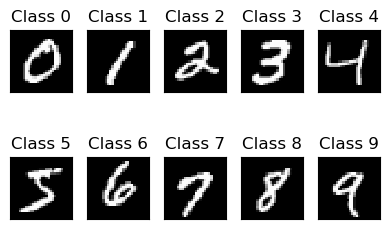

In [3]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)


X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator


In [5]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

seed_value = 42
init = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=seed_value
)

# Generator network
generator = tf.keras.models.Sequential()

# Input layer and hidden layer 1
generator.add(
    tf.keras.layers.Dense(
        128, input_shape=(latent_dim,), kernel_initializer=init
    )
)
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(tf.keras.layers.Dense(256))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(tf.keras.layers.Dense(512))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Output layer
generator.add(tf.keras.layers.Dense(img_dim, activation="tanh"))


2023-11-02 11:43:39.113284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 11:43:39.128455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 11:43:39.128563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 11:43:39.129114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [6]:
# prints a summary representation of your model
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

#### Discriminator

In [7]:
# Discriminator network
discriminator = tf.keras.models.Sequential()

# Hidden layer 1
discriminator.add(
    tf.keras.layers.Dense(128, input_shape=(img_dim,), kernel_initializer=init)
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(tf.keras.layers.Dense(256))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(tf.keras.layers.Dense(512))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(tf.keras.layers.Dense(1))


#### Discriminator model visualization

In [8]:
# prints a summary representation of your model
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

### 3. Compile model

#### Compile discriminator

In [9]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer, loss="mse", metrics=["binary_accuracy"]
)


#### Combined network

In [10]:
discriminator.trainable = False

z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = tf.keras.models.Model(inputs=z, outputs=decision)

# Optimize w.r.t. MSE loss instead of crossentropy
d_g.compile(optimizer=optimizer, loss="mse", metrics=["binary_accuracy"])


In [11]:
# prints a summary representation of your model
d_g.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               583312    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265601    
                                                                 
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


### 4. Fit model


2023-11-02 11:43:39.524770: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


epoch = 1/100, d_loss=0.141, g_loss=0.877                                                                                                                        
1/1 [==============================] - 0s 43ms/step


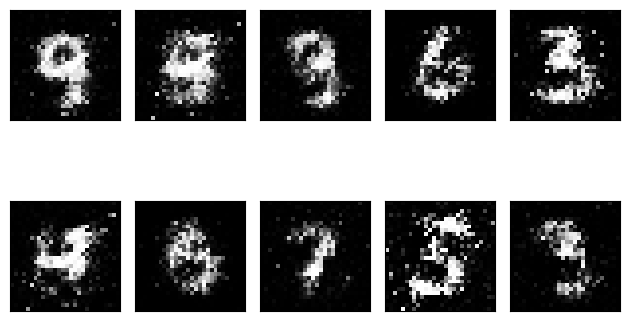

epoch = 2/100, d_loss=0.185, g_loss=0.370                                                                                                                        
epoch = 3/100, d_loss=0.220, g_loss=0.500                                                                                                                        
epoch = 4/100, d_loss=0.160, g_loss=0.300                                                                                                                        
epoch = 5/100, d_loss=0.208, g_loss=0.420                                                                                                                        
epoch = 6/100, d_loss=0.205, g_loss=0.310                                                                                                                        
epoch = 7/100, d_loss=0.198, g_loss=0.306                                                                                                                        
epoch = 8/100, d_loss=0.186,

2023-11-02 11:46:52.294132: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


2023-11-02 11:47:06.291714: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 11/100, d_loss=0.157, g_loss=0.430                                                                                                                        
1/1 [==============================] - 0s 11ms/step


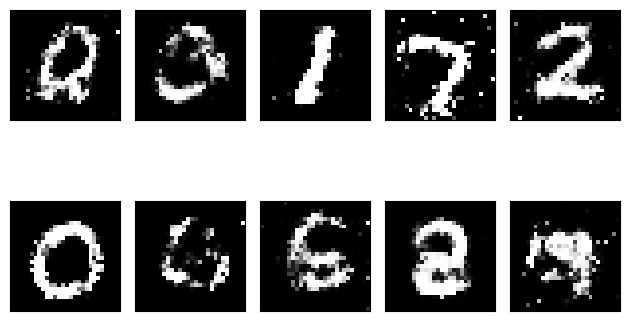

epoch = 12/100, d_loss=0.218, g_loss=0.394                                                                                                                        
epoch = 13/100, d_loss=0.195, g_loss=0.449                                                                                                                        


2023-11-02 11:48:06.292366: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 14/100, d_loss=0.178, g_loss=0.416                                                                                                                        
epoch = 15/100, d_loss=0.207, g_loss=0.463                                                                                                                        
epoch = 16/100, d_loss=0.171, g_loss=0.473                                                                                                                        
epoch = 17/100, d_loss=0.165, g_loss=0.412                                                                                                                        
epoch = 18/100, d_loss=0.205, g_loss=0.401                                                                                                                        
epoch = 19/100, d_loss=0.180, g_loss=0.487                                                                                                                        
epoch = 20/100, d_loss

2023-11-02 11:50:22.312750: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 21/100, d_loss=0.182, g_loss=0.440                                                                                                                        
1/1 [==============================] - 0s 12ms/step


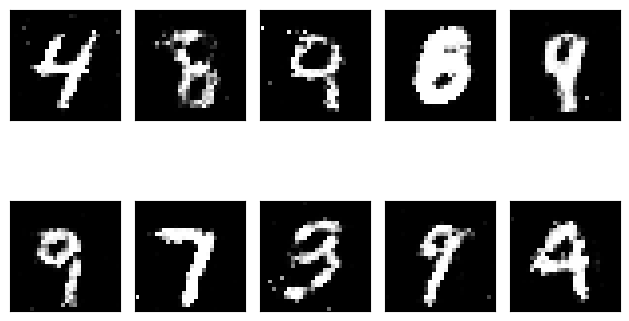

epoch = 22/100, d_loss=0.149, g_loss=0.436                                                                                                                        


2023-11-02 11:51:02.304420: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 23/100, d_loss=0.154, g_loss=0.458                                                                                                                        
epoch = 24/100, d_loss=0.179, g_loss=0.443                                                                                                                        
epoch = 25/100, d_loss=0.121, g_loss=0.433                                                                                                                        
epoch = 26/100, d_loss=0.139, g_loss=0.373                                                                                                                        
epoch = 27/100, d_loss=0.217, g_loss=0.522                                                                                                                        
epoch = 28/100, d_loss=0.139, g_loss=0.529                                                                                                                        
epoch = 29/100, d_loss

2023-11-02 11:53:32.321158: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 31/100, d_loss=0.164, g_loss=0.515                                                                                                                        
1/1 [==============================] - 0s 11ms/step


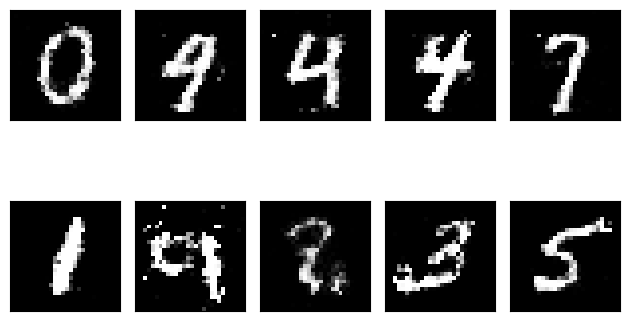

epoch = 32/100, d_loss=0.183, g_loss=0.496                                                                                                                        


2023-11-02 11:54:18.317459: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 33/100, d_loss=0.140, g_loss=0.415                                                                                                                        
epoch = 34/100, d_loss=0.157, g_loss=0.452                                                                                                                        
epoch = 35/100, d_loss=0.178, g_loss=0.450                                                                                                                        
epoch = 36/100, d_loss=0.189, g_loss=0.412                                                                                                                        
epoch = 37/100, d_loss=0.201, g_loss=0.473                                                                                                                        
epoch = 38/100, d_loss=0.130, g_loss=0.462                                                                                                                        
epoch = 39/100, d_loss

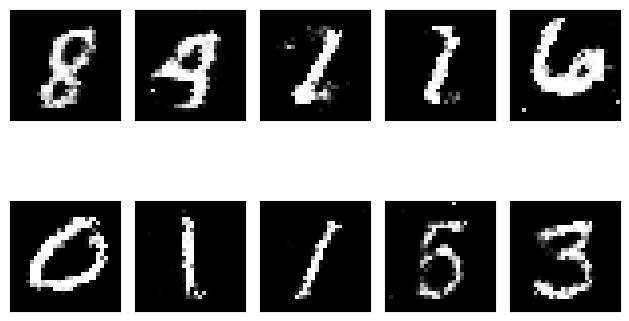

epoch = 42/100, d_loss=0.144, g_loss=0.526                                                                                                                        


2023-11-02 11:57:29.337691: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 43/100, d_loss=0.135, g_loss=0.557                                                                                                                        
epoch = 44/100, d_loss=0.146, g_loss=0.410                                                                                                                        
epoch = 45/100, d_loss=0.166, g_loss=0.498                                                                                                                        
epoch = 46/100, d_loss=0.142, g_loss=0.501                                                                                                                        
epoch = 47/100, d_loss=0.151, g_loss=0.470                                                                                                                        
epoch = 48/100, d_loss=0.135, g_loss=0.520                                                                                                                        
epoch = 49/100, d_loss

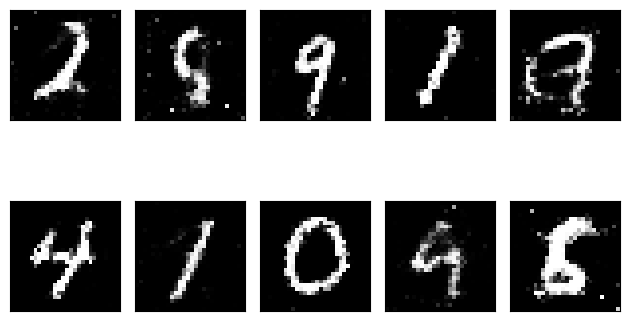

epoch = 52/100, d_loss=0.143, g_loss=0.485                                                                                                                        


2023-11-02 12:00:51.356026: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 53/100, d_loss=0.174, g_loss=0.604                                                                                                                        


2023-11-02 12:00:57.344737: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 54/100, d_loss=0.147, g_loss=0.496                                                                                                                        
epoch = 55/100, d_loss=0.159, g_loss=0.456                                                                                                                        
epoch = 56/100, d_loss=0.194, g_loss=0.587                                                                                                                        
epoch = 57/100, d_loss=0.105, g_loss=0.500                                                                                                                        
epoch = 58/100, d_loss=0.131, g_loss=0.556                                                                                                                        
epoch = 59/100, d_loss=0.126, g_loss=0.517                                                                                                                        
epoch = 60/100, d_loss

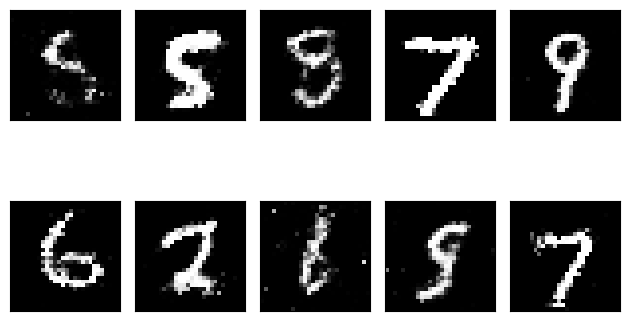

2023-11-02 12:03:37.356460: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 62/100, d_loss=0.153, g_loss=0.441                                                                                                                        
epoch = 63/100, d_loss=0.145, g_loss=0.592                                                                                                                        
epoch = 64/100, d_loss=0.158, g_loss=0.505                                                                                                                        
epoch = 65/100, d_loss=0.129, g_loss=0.599                                                                                                                        
epoch = 66/100, d_loss=0.187, g_loss=0.537                                                                                                                        


2023-11-02 12:05:25.369024: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 67/100, d_loss=0.151, g_loss=0.459                                                                                                                        


2023-11-02 12:05:45.369832: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 68/100, d_loss=0.121, g_loss=0.450                                                                                                                        


2023-11-02 12:05:53.367913: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


2023-11-02 12:06:03.367811: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 69/100, d_loss=0.184, g_loss=0.525                                                                                                                        
epoch = 70/100, d_loss=0.135, g_loss=0.487                                                                                                                        


2023-11-02 12:06:33.373256: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 71/100, d_loss=0.141, g_loss=0.547                                                                                                                        
1/1 [==============================] - 0s 11ms/step


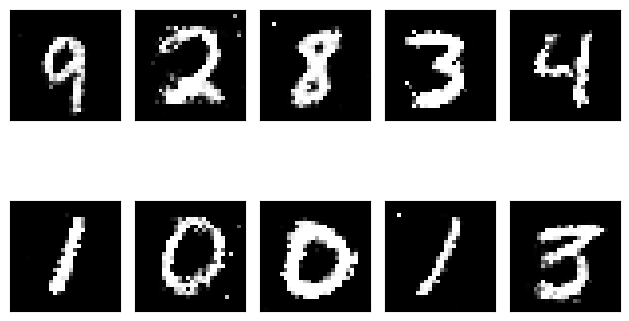

2023-11-02 12:07:01.371850: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 72/100, d_loss=0.142, g_loss=0.612                                                                                                                        
epoch = 73/100, d_loss=0.181, g_loss=0.657                                                                                                                        


2023-11-02 12:07:45.377509: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 74/100, d_loss=0.130, g_loss=0.475                                                                                                                        


2023-11-02 12:07:53.381431: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 75/100, d_loss=0.147, g_loss=0.572                                                                                                                        
epoch = 76/100, d_loss=0.147, g_loss=0.592                                                                                                                        
epoch = 77/100, d_loss=0.156, g_loss=0.600                                                                                                                        
epoch = 78/100, d_loss=0.129, g_loss=0.591                                                                                                                        
epoch = 79/100, d_loss=0.162, g_loss=0.624                                                                                                                        
epoch = 80/100, d_loss=0.124, g_loss=0.400                                                                                                                        
epoch = 81/100, d_loss

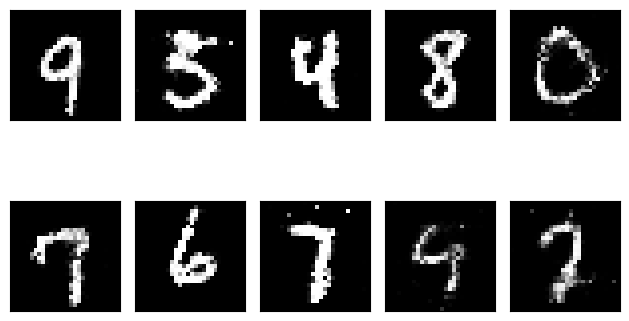

epoch = 82/100, d_loss=0.161, g_loss=0.464                                                                                                                        
epoch = 83/100, d_loss=0.126, g_loss=0.693                                                                                                                        
epoch = 84/100, d_loss=0.182, g_loss=0.651                                                                                                                        
epoch = 85/100, d_loss=0.152, g_loss=0.550                                                                                                                        
epoch = 86/100, d_loss=0.142, g_loss=0.387                                                                                                                        


2023-11-02 12:11:46.397509: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


2023-11-02 12:11:48.396613: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 87/100, d_loss=0.200, g_loss=0.549                                                                                                                        
epoch = 88/100, d_loss=0.165, g_loss=0.577                                                                                                                        
epoch = 89/100, d_loss=0.177, g_loss=0.638                                                                                                                        
epoch = 90/100, d_loss=0.176, g_loss=0.683                                                                                                                        
epoch = 91/100, d_loss=0.147, g_loss=0.356                                                                                                                        
1/1 [==============================] - 0s 12ms/step


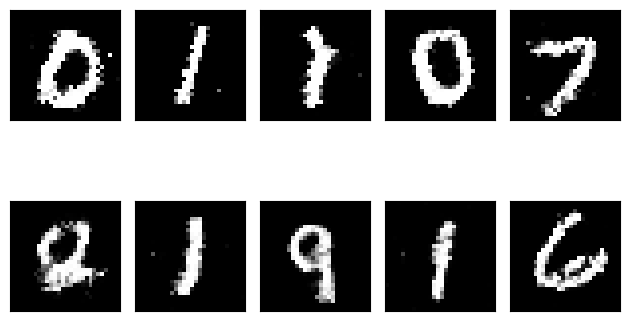

2023-11-02 12:13:34.398364: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 92/100, d_loss=0.143, g_loss=0.559                                                                                                                        
epoch = 93/100, d_loss=0.164, g_loss=0.466                                                                                                                        
epoch = 94/100, d_loss=0.199, g_loss=0.587                                                                                                                                                                                                                             


2023-11-02 12:14:36.406565: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 95/100, d_loss=0.228, g_loss=0.566                                                                                                                        
epoch = 96/100, d_loss=0.143, g_loss=0.500                                                                                                                        


2023-11-02 12:15:06.408588: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch = 97/100, d_loss=0.162, g_loss=0.587                                                                                                                        
epoch = 98/100, d_loss=0.129, g_loss=0.649                                                                                                                        
epoch = 99/100, d_loss=0.183, g_loss=0.600                                                                                                                        
epoch = 100/100, d_loss=0.182, g_loss=0.697                                                                                                                        
epoch = 101/100, d_loss=0.135, g_loss=0.561                                                                                                                        
1/1 [==============================] - 0s 12ms/step


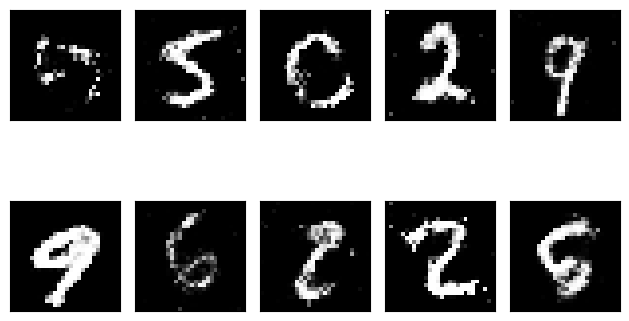

In [12]:
epochs = 100
batch_size = 32

a = tf.zeros(shape=(batch_size // 2, 1))
b = tf.ones(shape=(batch_size // 2, 1))
c = tf.ones(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_real = X_train[i * batch_size // 2 : (i + 1) * batch_size // 2]

        # Fake Samples
        z = tf.random.normal(
            shape=(batch_size // 2, latent_dim), mean=0, stddev=1
        )
        X_fake = generator.predict_on_batch(z)

        # Discriminator loss
        d_loss_batch = discriminator.train_on_batch(
            x=tf.concat((X_fake, X_real), axis=0),
            y=tf.concat((a, b), axis=0),
        )

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        d_g_loss_batch = d_g.train_on_batch(x=z, y=c)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch[0],
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch[0])
    d_g_loss.append(d_g_loss_batch[0])
    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict(z)

        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

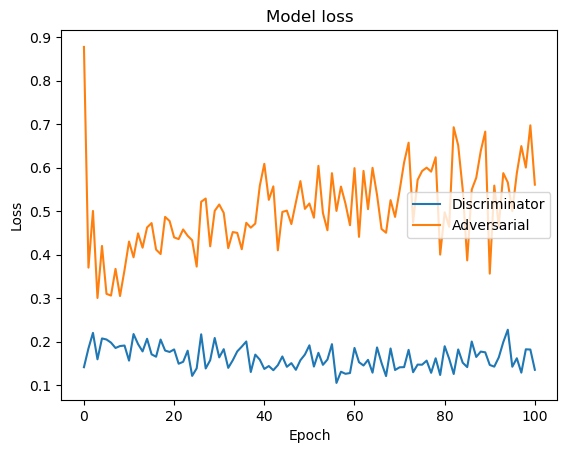

In [13]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()
